# HW1 Part 3: Large Scale Online Learning

Authors: 
- Farzan Memarian fm6996
- Timothy Mahler tam2643
- Meghana Venkata Palukuri mvp549

In [154]:
# DATA GENERATION

import numpy as np
from itertools import permutations
import random
import time
from pdb import set_trace

Nexam = 10**5
Ndim = 20
Nperm = 30
x1 = np.random.multivariate_normal(mean= np.ones(Ndim), cov =  np.identity(Ndim),size = Nexam)
y1 = np.ones(Nexam)
x2 = np.random.multivariate_normal(mean= -np.ones(Ndim), cov =  np.identity(Ndim),size = Nexam)
y2 = -np.ones(Nexam)

X = np.concatenate((x1,x2),axis=0)
y = np.concatenate((y1,y2))

from sklearn import model_selection
X_tr_orig, X_test_orig, y_tr_orig, y_test_orig = model_selection.train_test_split(X,y,test_size=0.5)

# reshaping y
y_tr_orig = y_tr_orig.reshape((len(y_tr_orig),1))
y_test_orig = y_test_orig.reshape((len(y_test_orig),1))

perms = [] # array storing different premutatins of X, Y
for _ in range(Nperm):
    inx = np.random.permutation(Nexam)
    X_perm = X_tr_orig[inx]
    y_perm = y_tr_orig[inx]
    perms.append([X_perm,y_perm])

In [19]:
# np.save('y_test', y_test_orig)
# np.save('X_test', X_test_orig)

In [21]:
# np.savetxt('y_test.txt', y_test_orig, fmt='%d')
# np.savetxt('X_test.txt', X_test_orig)

# A) Batch newton algorithm with the Gauss-Newton approximation

In [78]:
# FUNCTIONS
from numpy import outer, matmul, inner
from numpy.linalg import inv, norm
from scipy.sparse import diags
from sklearn.metrics import mean_squared_error

def func(X, theta):
    return  1.71 * np.tanh(0.66 * matmul(X, theta))

def f_prime(X, theta):
    return  1.71 * 0.66 *  (1 -  np.tanh(0.66 * matmul(X, theta))**2)

def gradient_loss(f, f_prime, y, X):
    N = len(y)
    g = np.zeros((Ndim,))
    for i in range(N):
        nabla_f_theta = f_prime[i] * X[i,:]
        g += 0.5 * 2 * (f[i] - 1.5*y[i]) * nabla_f_theta
    return g.reshape((Ndim,1))

def hessian(f_prime, X):
    h = np.zeros((Ndim,Ndim))
    N,_ = np.shape(X)
    for i in range(N):
        h += f_prime[i]**2 * np.outer(X[i,:],X[i,:])
    return h

def batch_newton_step(X, y, theta):

    f = func(X, theta)
#     print ("mse f, y: {}".format(mean_squared_error(f,y)) )
    f_p = f_prime(X, theta)
    g = gradient_loss(f, f_p, y, X)
    h = hessian(f_p, X)
    h_inv = inv(h)
    d_theta = -matmul(h_inv, g)
    return d_theta

def batch_newton_iter(X, y, theta_init, thresh):
    theta = theta_init
    keep_iter = True
    counter = 0
    while keep_iter:
#         counter += 1
#         if counter % 10 == 0:
#             print ("iter:", counter)
#             print ("error", norm(d_theta))
#             print ("threshold", thresh)
        d_theta = batch_newton_step(X, y, theta)

        if norm(d_theta) > thresh:
            theta += d_theta
        else:
            keep_iter = False
    return theta



In [3]:
# TRAINING BATCH NEWTON ALGORITHM

Nsizes = 5
n_ex_float = np.floor(np.logspace(3.0, 5.0, num=Nsizes))
n_ex = [int(item) for item in n_ex_float]
# n_ex = [100,1000]

theta_store_all_N = []
time_storage_N = []
for N in n_ex:
    print ("RUNNING FOR {} EXAMPLES".format(N))
    start_time = time.time()
    theta_store = []
    thresh = 0.01/N
    perm_counter = 0
    for X_all,y_all in perms:
        X = X_all[:N,:]
        y = y_all[:N]
        perm_counter += 1
        if perm_counter % 5 == 0:
            print ("perm counter: ", perm_counter)
        theta_init = np.random.uniform(-0.5, 0.5, size=Ndim).reshape((Ndim,1))
        theta = batch_newton_iter(X, y, theta_init, thresh)
        theta_store.append(theta)
    end_time = time.time()
    elapsed_time = end_time - start_time
    time_storage_N.append(elapsed_time)
    theta_store_all_N.append(theta_store)

RUNNING FOR 1000 EXAMPLES
perm counter:  5
perm counter:  10
perm counter:  15
perm counter:  20
perm counter:  25
perm counter:  30
RUNNING FOR 3162 EXAMPLES
perm counter:  5
perm counter:  10
perm counter:  15
perm counter:  20
perm counter:  25
perm counter:  30
RUNNING FOR 10000 EXAMPLES
perm counter:  5
perm counter:  10
perm counter:  15
perm counter:  20
perm counter:  25
perm counter:  30
RUNNING FOR 31622 EXAMPLES
perm counter:  5
perm counter:  10
perm counter:  15
perm counter:  20
perm counter:  25
perm counter:  30
RUNNING FOR 100000 EXAMPLES
perm counter:  5
perm counter:  10
perm counter:  15
perm counter:  20
perm counter:  25
perm counter:  30


In [4]:
# SAVE THETAS AND TIMES FOR NEWTON

import pickle

with open('theta_store_all_N.plk', 'wb') as fp:
    pickle.dump(theta_store_all_N, fp)
    
with open('time_storage_N.plk', 'wb') as fb:
    pickle.dump(time_storage_N, fb)

In [5]:
# FIND THETA* ON TEST SET USING NEWTON METHOD
        
N = len(y_test_orig)

thresh = 0.01/N

X = X_test_orig[:N,:]
y = y_test_orig[:N]

theta_init = np.random.uniform(-0.5, 0.5, size=Ndim).reshape((Ndim,1))
start_time = time.time()
theta_star = batch_newton_iter(X, y, theta_init, thresh)
np.save('theta_star', theta_star)
end_time = time.time()
elapsed_time_test = end_time - start_time
print ("elapsed time for test set: {}".format(elapsed_time_test))

elapsed time for test set: 259.43181562423706


In [22]:
np.savetxt('theta_star.txt', theta_star)

# B)  Implement the Online-Kalman algorithm 

In [215]:
def gradient(theta, x, y):
    y = np.asarray([y]).T
    f = np.tanh((2 / 3) * np.dot(x.T, theta))
    return -1 * 1.7159 * (2 / 3) * x * (1.5 * y - 1.7159 * f) * (1 - f ** 2)


def online_kalman(X, Y, N):
    phi = np.identity(Ndim)
    theta = np.random.uniform(-0.5, 0.5, size=Ndim).reshape((Ndim,1))
    
    start_time = time.time()

    for i in range(N):
        Xa = np.reshape(np.asarray(X[i, :]), (Ndim, 1))
        tau = max(20, i - 40)
        a = 1 - (2 / tau)
        AA = np.tanh(0.66 * np.dot(Xa.T, theta))

        fj = 1.71 * 0.66 * (1 - (AA ** 2))

        b = (2 / tau) * fj ** 2
        Au = np.matmul(phi, Xa)

        uTAu = np.dot(Xa.T, Au)
        AuAuT = np.matmul(Au, Au.T)
        g = gradient(theta, Xa, Y[i])
        phi = (1 / (a)) * (phi - (AuAuT) / ((a / b) + uTAu))

        theta = theta - (1 / tau) * np.matmul(phi, g)
    
    time_o_run = (time.time() - start_time)
    return (theta, time_o_run)

In [216]:
# TRAINING ONLINE KALMAN ALGORITHM

Nsizes = 5
n_ex_float = np.floor(np.logspace(3.0, 5.0, num=Nsizes))
n_ex = [int(item) for item in n_ex_float]
# n_ex = [5000,10000]

theta_store_all_K = []
time_storage_K = []
for N in n_ex:
    print ("RUNNING FOR {} EXAMPLES".format(N))
    
    theta_store = []
    perm_counter = 0
    start_time = time.time()
    for X_all,y_all in perms:
        X = X_all[:N,:]
        y = y_all[:N]
        perm_counter += 1
        if perm_counter % 5 == 0:
            print ("perm counter: ", perm_counter)
        theta, _ = online_kalman(X,y,N)
        theta_store.append(theta)
    end_time = time.time()
    elapsed_time = end_time - start_time
    time_storage_K.append(elapsed_time)
    theta_store_all_K.append(theta_store)

print ("Done!!")

RUNNING FOR 1000 EXAMPLES
perm counter:  5
perm counter:  10
perm counter:  15
perm counter:  20
perm counter:  25
perm counter:  30
RUNNING FOR 3162 EXAMPLES
perm counter:  5
perm counter:  10
perm counter:  15
perm counter:  20
perm counter:  25
perm counter:  30
RUNNING FOR 10000 EXAMPLES
perm counter:  5
perm counter:  10
perm counter:  15
perm counter:  20
perm counter:  25
perm counter:  30
RUNNING FOR 31622 EXAMPLES
perm counter:  5
perm counter:  10
perm counter:  15
perm counter:  20
perm counter:  25
perm counter:  30
RUNNING FOR 100000 EXAMPLES
perm counter:  5
perm counter:  10
perm counter:  15
perm counter:  20
perm counter:  25
perm counter:  30
Done!!


In [206]:
# SAVE THETAS AND TIMES FOR KALMAN
import pickle
    
with open('theta_store_all_K.plk', 'wb') as fp:
    pickle.dump(theta_store_all_K, fp)
    
with open('time_storage_K.plk', 'wb') as fb:
    pickle.dump(time_storage_K, fb)
    

# C) evaluations and figures

In [207]:
# Import packages
import matplotlib.pyplot as plt
import pickle
import numpy as np
from itertools import permutations
import random
import time

# Load in data

Nsizes = 5
ExamNums = [1000, 3162, 10000, 31622, 100000]
Nperm = 30

X_test_load = np.loadtxt("X_test.txt")
y_test_load = np.loadtxt("y_test.txt")
theta_star = np.loadtxt("theta_star.txt")

theta_store_all_K_load = pickle.load( open( "theta_store_all_K.plk", "rb" ))
time_storage_K_load = pickle.load( open( "time_storage_K.plk", "rb" ))

theta_store_all_N_load = pickle.load( open( "theta_store_all_N.txt", "rb" )) 
time_storage_N_load = pickle.load( open( "time_storage_N.txt", "rb" ))

print ("Done loading")

Done loading


In [214]:
# Evalutaion
def calc_evaluations(theta_store):
    
    store_mse_normalized = []
    store_theta_diff = []
    X = X_test_load
    y = y_test_load
    
    for i, N in enumerate(ExamNums):
        mse = 0
        theta_diff = 0
        
        for j in range(Nperm):
            theta = theta_store[i][j]
            f = func(X, theta)
            mse += mean_squared_error(f, 1.5*y)/ Nperm
            theta_diff += norm(theta - theta_star)**2
            
        f_star = func(X, theta_star)
        mse_star = mean_squared_error(f_star, 1.5*y)
        
        store_theta_diff.append(theta_diff)
        store_mse_normalized.append(abs(mse-mse_star))
    
    return (store_theta_diff, store_mse_normalized)

# Newton
(theta_diff_N, mse_N) = calc_evaluations(theta_store_all_N_load)

# Kalman (online)
(theta_diff_K, mse_K) = calc_evaluations(theta_store_all_K_load)

print ("For N Examples")
print (ExamNums)

print ("\n\nNewton")
print ("Theta Diff")
print (theta_diff_N)
print ("MSE")
print (mse_N)

print ("\n\nKalman")
print ("Theta Diff")
print (theta_diff_K)
print ("MSE")
print (mse_K)

For N Examples
[1000, 3162, 10000, 31622, 100000]


Newton
Theta Diff
[5.230125284161369, 1.654669251725445, 0.5488089192727466, 0.18861215138766976, 0.08162273864929236]
MSE
[0.0015251057517819099, 0.0004905336083212142, 0.0002326895761782105, 0.00013345042983784958, 9.727012173955246e-05]


Kalman
Theta Diff
[9.726711808992533, 4.41851293459649, 2.936492575747337, 2.8187884018794596, 2.8528643418636817]
MSE
[0.0015257455468966168, 0.004350212356545761, 0.005181315765005957, 0.00543592091408392, 0.005510609109856457]


## (θ−θ*)^2 by Num Examples

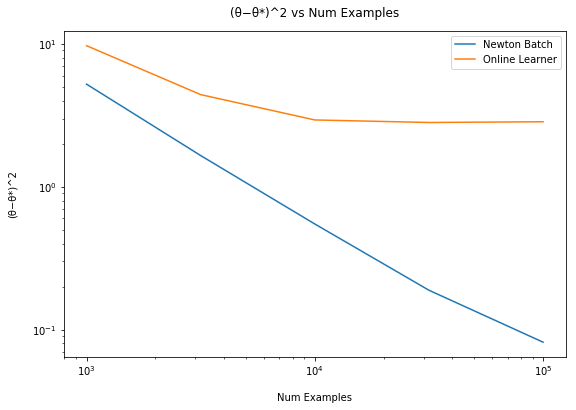

In [209]:
plt.figure(figsize=(9,6))
plt.loglog(ExamNums, theta_diff_N)
plt.loglog(ExamNums, theta_diff_K)
plt.xlabel("Num Examples", labelpad=15)
plt.ylabel("(θ−θ*)^2", labelpad=15)
plt.title("(θ−θ*)^2 vs Num Examples", y=1.025)
plt.legend(['Newton Batch', 'Online Learner'], loc='upper right')

## (θ−θ*)^2 by Time

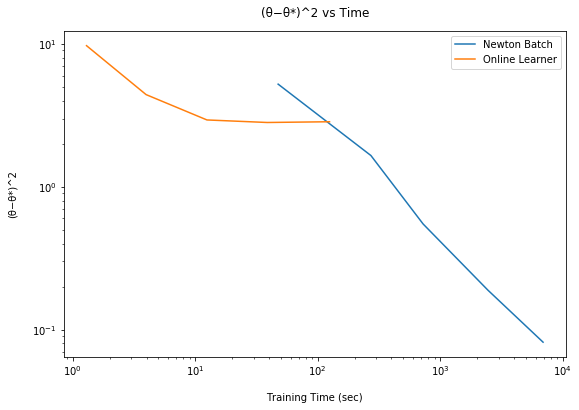

In [210]:
plt.figure(figsize=(9,6))
plt.loglog(time_storage_N_load, theta_diff_N)
plt.loglog(time_storage_K, theta_diff_K)
plt.xlabel("Training Time (sec)", labelpad=15)
plt.ylabel("(θ−θ*)^2", labelpad=15)
plt.title("(θ−θ*)^2 vs Time", y=1.025)
plt.legend(['Newton Batch', 'Online Learner'], loc='upper right')

## Avg Test MSE by Num Examples

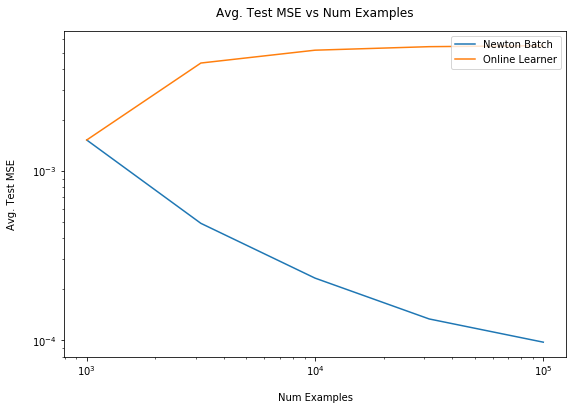

In [211]:
plt.figure(figsize=(9,6))
plt.loglog(ExamNums, mse_N)
plt.loglog(ExamNums, mse_K)
plt.xlabel("Num Examples", labelpad=15)
plt.ylabel("Avg. Test MSE", labelpad=15)
plt.title("Avg. Test MSE vs Num Examples", y=1.025)
plt.legend(['Newton Batch', 'Online Learner'], loc='upper right')

## Avg Test MSE by Time

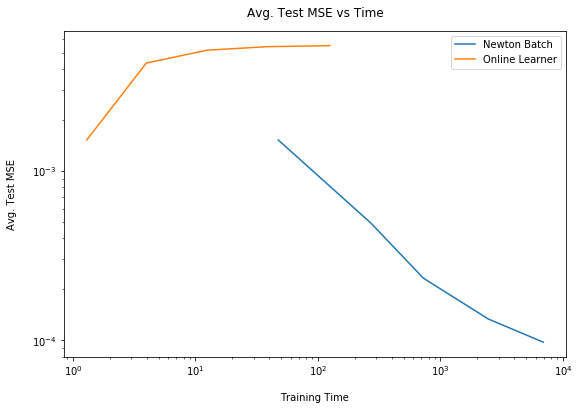

In [212]:
plt.figure(figsize=(9,6))
plt.loglog(time_storage_N_load, mse_N)
plt.loglog(time_storage_K_load, mse_K)
plt.xlabel("Training Time", labelpad=15)
plt.ylabel("Avg. Test MSE", labelpad=15)
plt.title("Avg. Test MSE vs Time", y=1.025)
plt.legend(['Newton Batch', 'Online Learner'], loc='upper right')